# Config

In [35]:
from datetime import datetime
from datetime import timedelta
import time

from pytz import UTC # timezone
import time
import numpy as np
import pandas as pd
from pandas import read_excel
import matplotlib.pyplot as plt

import pandas as pd

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

def DF_TO_EXCEL(df, filename, sheet_name):
    sheet_name = 'Sheet1' if len(sheet_name) == 0 else sheet_name
    writer = pd.ExcelWriter(filename)
    df.to_excel(writer, sheet_name)
    writer.save()
    
def DF_TO_EXCEL_MUL(dfs, filename):
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    for sheetname, df in dfs.items():  # loop through `dict` of dataframes
        df.to_excel(writer, sheet_name=sheetname)  # send df to writer
        worksheet = writer.sheets[sheetname]  # pull worksheet object
        for idx, col in enumerate(df):  # loop through all columns
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # len of largest item
                len(str(series.name))  # len of column name/header
                )) + 1  # adding a little extra space
            worksheet.set_column(idx, idx, max_len)  # set column width
    writer.save()
    
def convertMillis(millis):
    seconds=(millis/1000)%60
    minutes=(millis/(1000*60))%60
    hours=(millis/(1000*60*60))%24
    return int(seconds), int(minutes), int(hours)

def data_to_pandas(pair_data):
    # Create pandas data frame and clean/format data
    names = ['time', 'open', 'close', 'high', 'low', 'volume']
    df = pd.DataFrame(pair_data, columns=names)
    df.drop_duplicates(inplace=True)
    df['time'] = pd.to_datetime(df['time'], unit='ms')
    df.set_index('time', inplace=True)
    df.sort_index(inplace=True)
    return df

def fetch_data(start, stop, symbol, interval, tick_limit, step):
    # Create api instance
    api_v2 = bitfinex.bitfinex_v2.api_v2(key, secrete)
    data = []
    start = start - step
    while start < stop:
        start = start + step
        end = start + step
        res = api_v2.candles(symbol=symbol, interval=interval,
                             limit=tick_limit, start=start,
                             end=end)
        data.extend(res)
        time.sleep(1)
    return data


# bitfinex Check account

In [36]:
import bitfinex

key = 'API KEY'
secrete = 'API KEY SECRET'

# Create api instance of the v2 API
api_v2 = bitfinex.bitfinex_v2.api_v2(key, secrete)

## List Cryto pairs

In [37]:
# Initialize V1 API
apiV1 = bitfinex.bitfinex_v1.api_v1(key, secrete)

# Get the names of all pairs
pairs = apiV1.symbols()

print(pairs[:20])

get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
idx = get_indexes("xrpusd",pairs)
print(idx[0])
if len(idx) > 0:
    print(pairs[idx[0]])

['btcusd', 'ltcusd', 'ltcbtc', 'ethusd', 'ethbtc', 'etcbtc', 'etcusd', 'rrtusd', 'rrtbtc', 'zecusd', 'zecbtc', 'xmrusd', 'xmrbtc', 'dshusd', 'dshbtc', 'btceur', 'btcjpy', 'xrpusd', 'xrpbtc', 'iotusd']
17
xrpusd


# Fetch data from bitfinex

## Fetch new data for new user

In [18]:
for pair in pairs:
    try:
        print(pair)
        bin_size = '1h' # This will return minute data and Time interval to bucket by. Available options: [1m,5m,1h,1d].
        limit = 5000    # We want the maximum of 1000 data points 
        # Set step size
        time_step = limit * 5 * 60 * 1000 # x bin_size to mili sec

        # Define the start date 
        t_start = datetime(2019, 1, 1, 0, 0)
        t_start = time.mktime(t_start.timetuple()) * 1000

        # Define the end date
        t_stop = datetime(2019, 9, 12, 0, 0)
        t_stop = time.mktime(t_stop.timetuple()) * 1000

        pair_data = fetch_data(start=t_start, stop=t_stop, symbol=pair,
                               interval=bin_size, tick_limit=limit, 
                               step=time_step)
        print('data size: {}'.format(len(pair_data)))
        last_index = pair_data.index('error') if pair_data.index('error') > 0 else len(pair_data)
        df = data_to_pandas(pair_data[:last_index])

        df['atr'] = 0
        df['atr_sma'] = 0
        df['zone'] = 0
        df = df[['open', 'close', 'high', 'low', 'volume', 'atr', 'atr_sma', 'zone']]

        path = 'data'
        filename = '{}/{}_{}.xlsx'.format(path, pair, bin_size)
        sheet_name = pair
        DF_TO_EXCEL(df, filename, sheet_name)
        print(filename)
        print('---------------------------')
    except:
        print('---------------------------')
        pass
    

x
data size: 6
---------------------------
r
data size: 6
---------------------------
p
data size: 6
---------------------------
u
data size: 6
---------------------------
s
data size: 6
---------------------------
d
data size: 6
---------------------------


## Load Current Data

In [38]:
# Define query parameters
pair = 'xrpusd' # Currency pair of interest
bin_size = '1h' # This will return minute data and Time interval to bucket by. Available options: [1m,5m,1h,1d].
limit = 5000    # We want the maximum of 1000 data points 
# Set step size
time_step = limit * 5 * 60 * 1000 # x bin_size to mili sec

# Define the start date 
t_start = datetime(2019, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000

# Define the end date
t_stop = datetime(2019, 8, 27, 0, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000

pair_data = fetch_data(start=t_start, stop=t_stop, symbol=pair,
                       interval=bin_size, tick_limit=limit, 
                       step=time_step)

last_index = pair_data.index('error') if pair_data.index('error') > 0 else len(pair_data)
df = data_to_pandas(pair_data[:last_index])

df['atr'] = 0
df['atr_sma'] = 0
df['zone'] = 0
df = df[['open', 'close', 'high', 'low', 'volume', 'atr', 'atr_sma', 'zone']]

path = 'data'
filename = '{}/{}_{}.xlsx'.format(path, pair, bin_size)
sheet_name = pair
DF_TO_EXCEL(df, filename, sheet_name)
print(filename)
df.info()

data/xrpusd_1h.xlsx
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5821 entries, 2018-12-31 17:00:00 to 2019-08-31 18:00:00
Data columns (total 8 columns):
open       5821 non-null float64
close      5821 non-null float64
high       5821 non-null float64
low        5821 non-null float64
volume     5821 non-null float64
atr        5821 non-null int64
atr_sma    5821 non-null int64
zone       5821 non-null int64
dtypes: float64(5), int64(3)
memory usage: 409.3 KB


# Load Old data from Excel

In [39]:
pair = pair if len(pair) > 0 else 'x'
path = 'data'
bin_size = '1h'
filename = '{path}/{pair}_{bin_size}.xlsx'.format(path=path, pair=pair, bin_size=bin_size)
sheet_name = pair
df = pd.read_excel(filename, sheet_name=sheet_name, index_col='time')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5821 entries, 2018-12-31 17:00:00 to 2019-08-31 18:00:00
Data columns (total 8 columns):
open       5821 non-null float64
close      5821 non-null float64
high       5821 non-null float64
low        5821 non-null float64
volume     5821 non-null float64
atr        5821 non-null int64
atr_sma    5821 non-null int64
zone       5821 non-null int64
dtypes: float64(5), int64(3)
memory usage: 409.3 KB


## Load Current Data & Merge

In [40]:
import datetime
import time

# Define query parameters
pair = pair if len(pair) > 0 else 'x' # Currency pair of interest
bin_size = '1h' # This will return minute data
limit = 5000    # We want the maximum of 1000 data points 
# Define the start date
t_start = datetime.datetime(2019, 1, 1, 0, 0)
t_start = time.mktime(t_start.timetuple()) * 1000
# Define the end date
t_stop = datetime.datetime(2019, 9, 12, 12, 0)
t_stop = time.mktime(t_stop.timetuple()) * 1000
pair_data1= api_v2.candles(symbol=pair, interval=bin_size,  
                        limit=limit, start=t_start, end=t_stop)
df1 = data_to_pandas(pair_data1)
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2019-02-15 14:00:00 to 2019-09-12 05:00:00
Data columns (total 5 columns):
open      5000 non-null float64
close     5000 non-null float64
high      5000 non-null float64
low       5000 non-null float64
volume    5000 non-null float64
dtypes: float64(5)
memory usage: 234.4 KB


In [41]:
df1['atr'] = 0
df1['atr_sma'] = 0
df1['zone'] = 0
df1 = df1[['open', 'close', 'high', 'low', 'volume', 'atr', 'atr_sma', 'zone']]
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5000 entries, 2019-02-15 14:00:00 to 2019-09-12 05:00:00
Data columns (total 8 columns):
open       5000 non-null float64
close      5000 non-null float64
high       5000 non-null float64
low        5000 non-null float64
volume     5000 non-null float64
atr        5000 non-null int64
atr_sma    5000 non-null int64
zone       5000 non-null int64
dtypes: float64(5), int64(3)
memory usage: 351.6 KB


In [42]:
end_date = df[-1:].index.values[0]
end_date

numpy.datetime64('2019-08-31T18:00:00.000000000')

In [43]:
df1 = df1.loc[df1.index > end_date]
df1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 274 entries, 2019-08-31 19:00:00 to 2019-09-12 05:00:00
Data columns (total 8 columns):
open       274 non-null float64
close      274 non-null float64
high       274 non-null float64
low        274 non-null float64
volume     274 non-null float64
atr        274 non-null int64
atr_sma    274 non-null int64
zone       274 non-null int64
dtypes: float64(5), int64(3)
memory usage: 19.3 KB


## Merge Data

In [44]:
df_excel = df.copy()

In [45]:
# merge data
frames = [df_excel, df1]
_df = pd.concat(frames)
df = _df.copy()
_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6095 entries, 2018-12-31 17:00:00 to 2019-09-12 05:00:00
Data columns (total 8 columns):
open       6095 non-null float64
close      6095 non-null float64
high       6095 non-null float64
low        6095 non-null float64
volume     6095 non-null float64
atr        6095 non-null int64
atr_sma    6095 non-null int64
zone       6095 non-null int64
dtypes: float64(5), int64(3)
memory usage: 428.6 KB


## Calculate Zone

In [46]:
zone_len = 25
df['zone'] = df['close'].apply(lambda x: (x - (x%zone_len) ))
df_time_in_the_zone = df.groupby('zone').count()[['close']]

df_time_in_the_zone.rename(columns={'close': 'count_point'}, inplace=True)

df_time_in_the_zone['time_sec'] = df_time_in_the_zone['count_point'] * 60 * 60 #piont * 5min * 60sec
df_time_in_the_zone['str_time'] = df_time_in_the_zone['time_sec'].apply(lambda x: str(timedelta(seconds=x)))
df_time_in_the_zone.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 1 entries, 0.0 to 0.0
Data columns (total 3 columns):
count_point    1 non-null int64
time_sec       1 non-null int64
str_time       1 non-null object
dtypes: int64(2), object(1)
memory usage: 32.0+ bytes


## Calculate ATR

In [47]:
import talib as ta

timeperiod = 14

high = df.high.values
low = df.low.values
close = df.close.values

atr = ta.ATR(high, low, close, timeperiod=timeperiod)
atr_sma = ta.SMA(atr, timeperiod)
atr_sma[0:timeperiod] = 0
atr[0:timeperiod] = 0
df['atr'] = atr
df['atr_sma'] = atr_sma

df = df.fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6095 entries, 2018-12-31 17:00:00 to 2019-09-12 05:00:00
Data columns (total 8 columns):
open       6095 non-null float64
close      6095 non-null float64
high       6095 non-null float64
low        6095 non-null float64
volume     6095 non-null float64
atr        6095 non-null float64
atr_sma    6095 non-null float64
zone       6095 non-null float64
dtypes: float64(8)
memory usage: 428.6 KB


In [30]:
list(df)

['open', 'close', 'high', 'low', 'volume', 'atr', 'atr_sma', 'zone']

# Export to Excel

In [48]:
pair = pair if len(pair) > 0 else 'x'
path = 'data'
filename = '{}/{}_{}.xlsx'.format(path, pair, bin_size)
sheet_name = pair
DF_TO_EXCEL(df, filename, sheet_name)
print(filename)

data/xrpusd_1h.xlsx


# Analyzing time series data in Pandas

In [49]:
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')


## Plot 

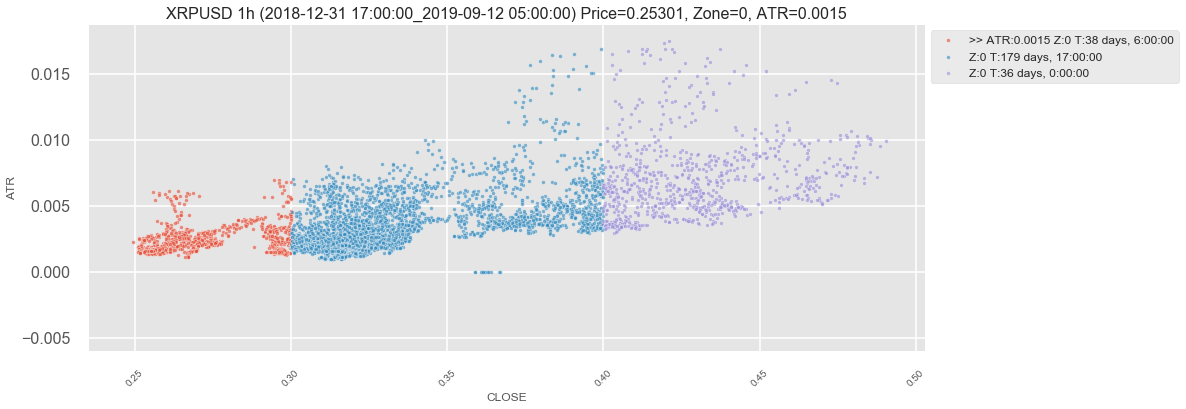

In [63]:
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

pair = pair if len(pair) > 0 else 'x'
path = 'data'
bin_size = '1h'

filename = '{}/{}_{}.xlsx'.format(path, pair, bin_size)
sheet_name = pair
df = pd.read_excel(filename, sheet_name=sheet_name, index_col='time')

date_start = df[0:1].index[0]
date_end = df[-1:].index[0]
price = df[-1:].close.values[0]
zone = df[-1:].zone.values[0]
atr = df[-1:].atr.values[0]

min_price = df['close'].min(axis = 0, skipna = True)
max_price = df['close'].max(axis = 0, skipna = True)

zone_len = 500 if max_price > 5000 else 0.1  # manage zone

# Calculate Zone
df['zone'] = df['close'].apply(lambda x: (x-(x%zone_len)))
df_time_in_the_zone = df.groupby('zone').count()[['close']]
df_time_in_the_zone.rename(columns={'close': 'count_point'}, inplace=True)
df_time_in_the_zone['time_sec'] = df_time_in_the_zone['count_point'] * 60 * 60 #point * 60min * 60sec
df_time_in_the_zone['str_time'] = df_time_in_the_zone['time_sec'].apply(lambda x: str(timedelta(seconds=x)))

# Setup Chart
fig, ax = plt.subplots(figsize=(15,6))

for idx,row in df_time_in_the_zone.iterrows():
    close = df.loc[df.zone == idx].close.values[0]
    close = close - (close%zone_len)
    cur_zone = '>> ATR:%s '%round(atr,4) if (price - (price%zone_len)) == close else ''
    label = '{}Z:{} T:{}'.format(cur_zone, str(int(idx)), row.str_time)
    
    x = df.loc[df.zone == idx].close.values
    y = df.loc[df.zone == idx].atr.values
    scale = 15
    
    ax.scatter(x, y, s=scale, label=label, alpha=0.6, edgecolors='white', cmap='Accent', marker="o")    
    
ax.legend(bbox_to_anchor=(1, 1), fontsize = 'large')
ax.grid(True)

plt.xlabel('CLOSE')
plt.ylabel('ATR')
plt.title('{} {} ({}_{}) Price={}, Zone={}, ATR={}'.format(pair.upper(), bin_size, date_start,
                                                         date_end, price, round(zone,4), round(atr,4)), fontsize=16)
#plt.xticks(range(int(min_price), int(max_price), zone_len))
plt.xticks(fontsize=10, rotation=45)
plt.tick_params(axis='both', which='minor', labelsize=10)
#plt.savefig('data/{pair}.png'.format(pair=pair))
plt.show()

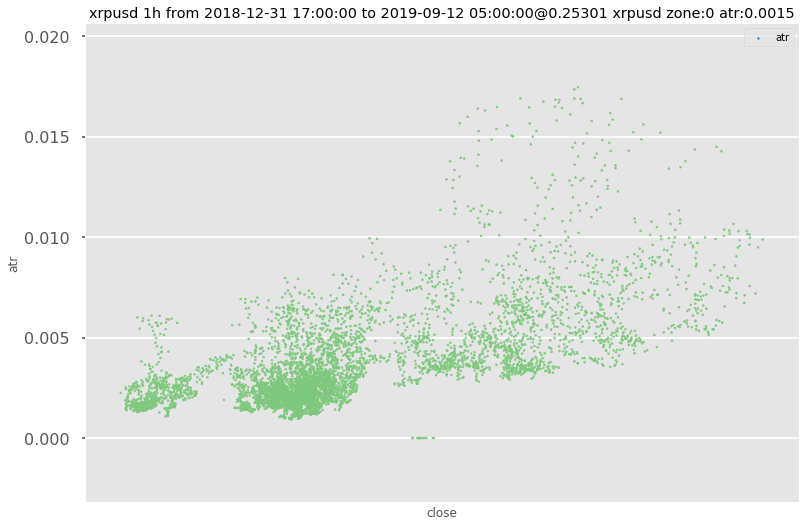

In [55]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')

import datetime

pair = pair if len(pair) > 0 else 'x'

date_start = df[0:1].index[0]
date_end = df[-1:].index[0]
price = df[-1:].close.values[0]
zone = df[-1:].zone.values[0]
atr = df[-1:].atr.values[0]

min_price = df['close'].min(axis=0, skipna=True)
max_price = df['close'].max(axis=0, skipna=True)

fig, ax = plt.subplots()
ax.scatter(x=df.close, y=df.atr, s = 4
            , alpha = 0.9, c=df.zone
            , cmap='Accent')
ax.legend(bbox_to_anchor=(1, 1), fontsize = 'medium')

plt.xlabel('close')
plt.ylabel('atr')
plt.title('{pair} {bin_size} from {date_start} to {date_end}@{price} {pair} zone:{zone} atr:{atr}'
          .format(pair=pair, bin_size=bin_size, date_start=date_start, date_end=date_end, price=price, zone=int(zone), atr=round(atr,4)))
plt.xticks(range(int(min_price), int(max_price), zone_len))
plt.xticks(rotation=90)
plt.show()

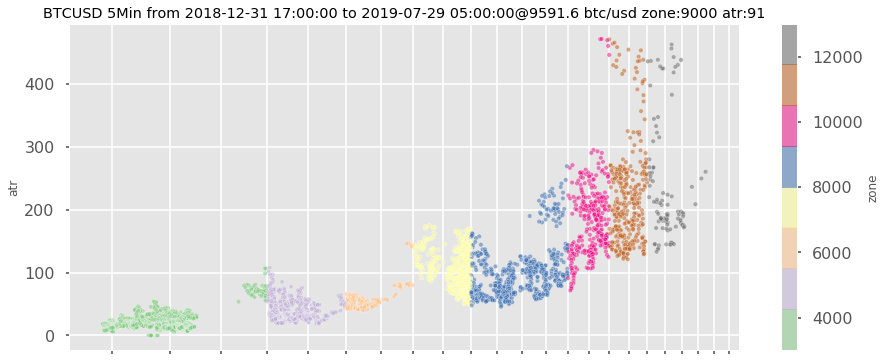

In [8]:
import numpy as np

date_start = df[0:1].index[0]
date_end = df[-1:].index[0]
price = df[-1:].close.values[0]
zone = df[-1:].zone.values[0]
atr = df[-1:].atr.values[0]
ax = df.plot.scatter(figsize=(15,6),
               x='close', y='atr', c='zone', cmap='Accent',
               title = 'BTCUSD 5Min from {} to {}@{} btc/usd zone:{} atr:{}'.format(date_start, date_end, price, int(zone), int(atr)),
               logx = 'True',
               edgecolors='white',
               alpha=0.5,
               xticks=range(3500,15000,500))



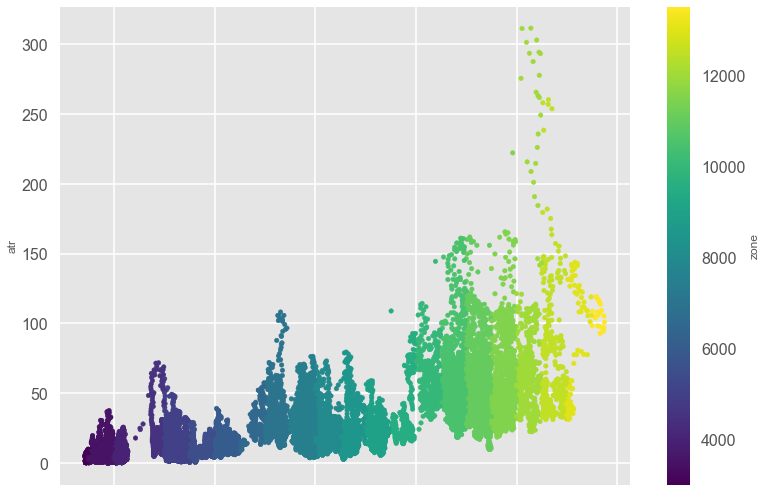

In [215]:
ax = df.loc[:].plot.scatter(x='close',y='atr',c='zone',colormap='viridis')

## Test seaborn

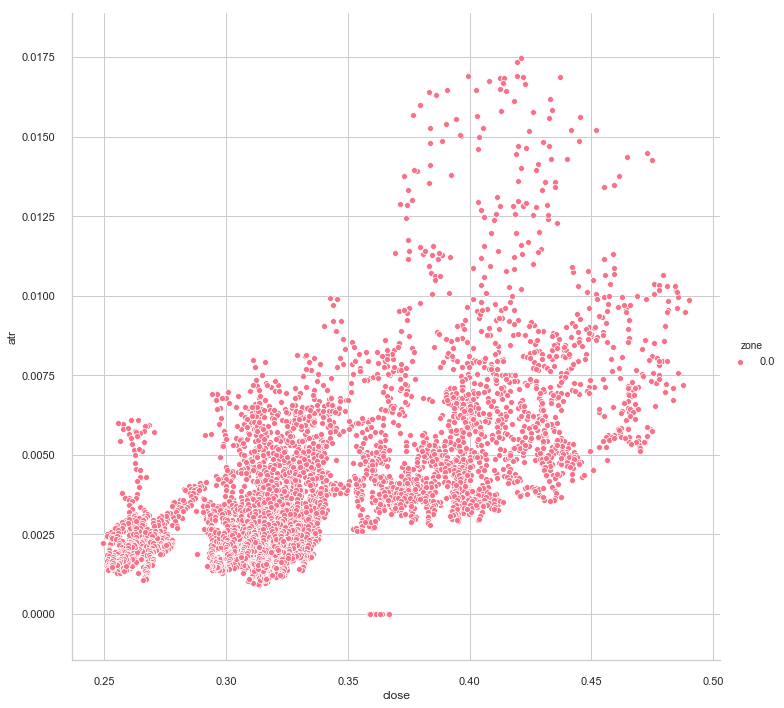

In [56]:
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid", color_codes=True)

sns.pairplot(x_vars=["close"], y_vars=["atr"], data=df, hue="zone", height=10, markers="o", palette="husl")

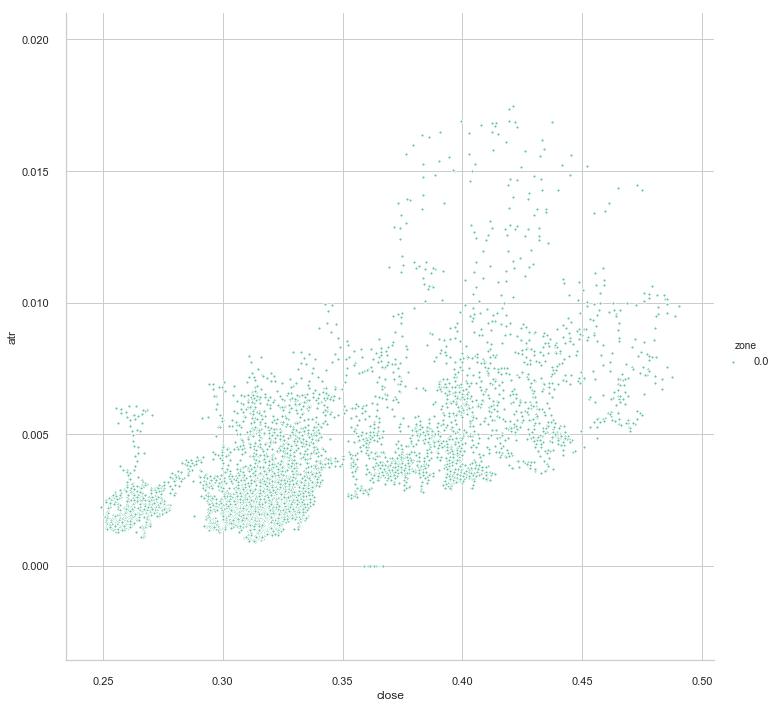

In [57]:
g = sns.PairGrid(df, x_vars=["close"], y_vars=["atr"], hue="zone", height=10, palette="Set2")
g = g.map(plt.scatter, linewidths=1, edgecolor='w', s=10)
g = g.add_legend()

In [154]:
import matplotlib.pyplot as plt
import random

number_of_colors = len(df_time_in_the_zone.index.values)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]


## Test OHLC

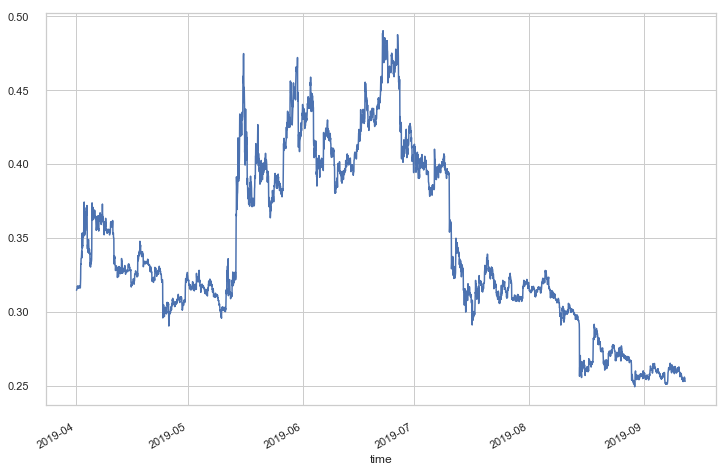

In [58]:
import matplotlib
matplotlib.rcParams['figure.figsize'] =[12.0, 8.0]
from datetime import datetime
start_date = datetime(2019,4,1)
end_date = datetime(2019,12,31)
df['close'][(df.index >= start_date) & ( df.index <= end_date)].plot(grid=True)
#df['close'].loc[df['zone'] == 5].plot(grid=True)
#df['close'].loc[df['zone'] == 5].plot(kind='box', figsize=[16,8])

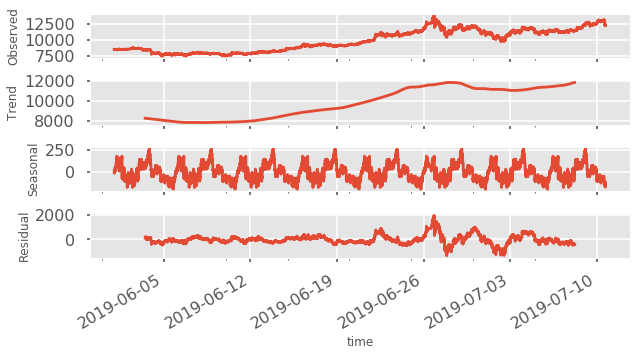

In [75]:
import statsmodels.api as sm
from datetime import datetime

start_date = datetime(2019,6,1)
end_date = datetime(2019,7,19)

data = df['close'][(df.index >= start_date) & ( df.index <= end_date)]
decomposition = sm.tsa.seasonal_decompose(data, freq=60*24, model = 'additive')
fig = decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [9.0, 5.0]

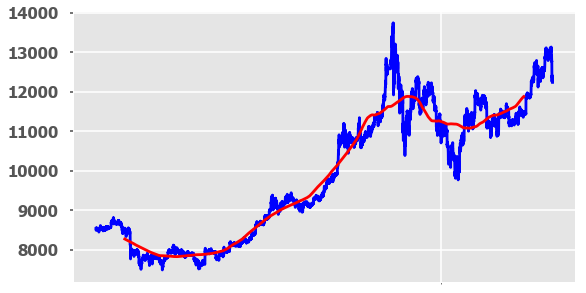

In [93]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
fig, ax = plt.subplots()
ax.grid(True)
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=3)
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
plt.plot(data.index, df['close'][(df.index >= start_date) & ( df.index <= end_date)], c='blue')
plt.plot(decomposition.trend.index, decomposition.trend, c='red')